In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [2]:
housing_data = pd.read_csv('Bangalore.csv')
housing_data.head() 

,Price,Area,Location,NumBedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,30000000,3340,JP Nagar Phase 1,4,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,8358000,1675,Doddanekundi,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6845000,1670,Kengeri,3,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [3]:
varlist = ['Price','Area','NumBedrooms','Resale','MaintenanceStaff','Gymnasium','SwimmingPool','LandscapedGardens','IndoorGames']
data = housing_data[varlist].copy()

In [4]:
# checking for null values
print(data.info())

# checking for outliers
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6207 entries, 0 to 6206
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Price              6207 non-null   int64
 1   Area               6207 non-null   int64
 2   NumBedrooms        6207 non-null   int64
 3   Resale             6207 non-null   int64
 4   MaintenanceStaff   6207 non-null   int64
 5   Gymnasium          6207 non-null   int64
 6   SwimmingPool       6207 non-null   int64
 7   LandscapedGardens  6207 non-null   int64
 8   IndoorGames        6207 non-null   int64
dtypes: int64(9)
memory usage: 436.5 KB
None
              Price         Area  NumBedrooms       Resale  MaintenanceStaff  \
count  6.207000e+03  6207.000000  6207.000000  6207.000000       6207.000000   
mean   1.058510e+07  1526.094248     2.556952     0.078782          6.208797   
std    1.410943e+07   764.845609     0.694300     0.269420          4.126883   
min    2.000000e+06   4

Text(0, 0.5, 'Price')

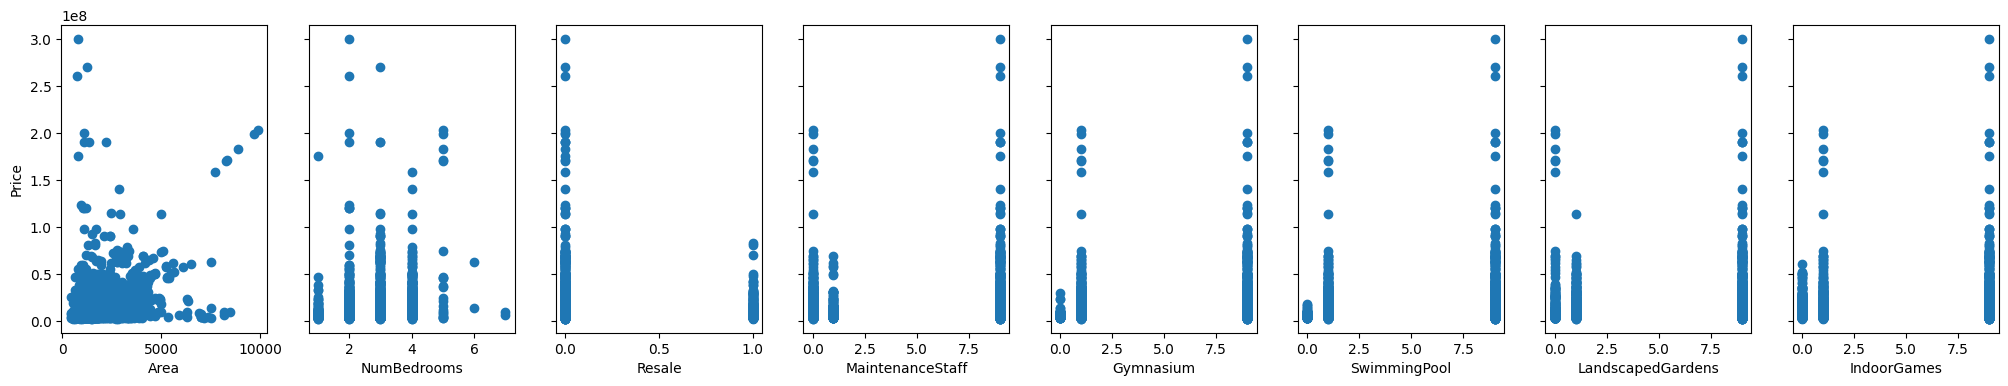

In [5]:
# some of the features like Gymnaisum should have bool values and the mean should not be more than 1
# plotting the to check if scaling is required
fig,ax = plt.subplots(1,8, figsize=(25,4), sharey = True)
for i in range(len(ax)):
    ax[i].scatter(data[varlist[i+1]],data[varlist[0]])
    ax[i].set_xlabel(varlist[i+1])
ax[0].set_ylabel('Price')

In [6]:
# MainenanceStaff, Gymnasium, SwimmingPool, LandscapedGardens and IndoorGames needs to be manipulated
MaintenanceStaff = [1 if i>1 else 0 for i in data.MaintenanceStaff]
Gymnasium = [1 if i>1 else 0 for i in data.Gymnasium]
SwimmingPool = [1 if i>1 else 0 for i in data.SwimmingPool]
LandscapedGardens = [1 if i>1 else 0 for i in data.LandscapedGardens]
IndoorGames = [1 if i>1 else 0 for i in data.IndoorGames]

In [7]:
# all the features are scaled except Area and NumBedrooms
# performing z-score normalization on Area
std_dev = np.std(data.Area)
mean = np.mean(data.Area)
Area = [(i-mean)/std_dev for i in data.Area]

# performing z-score normalization on NumBedrooms
std_dev = np.std(data.NumBedrooms)
mean = np.mean(data.NumBedrooms)
NumBedrooms = [(i-mean)/std_dev for i in data.NumBedrooms]

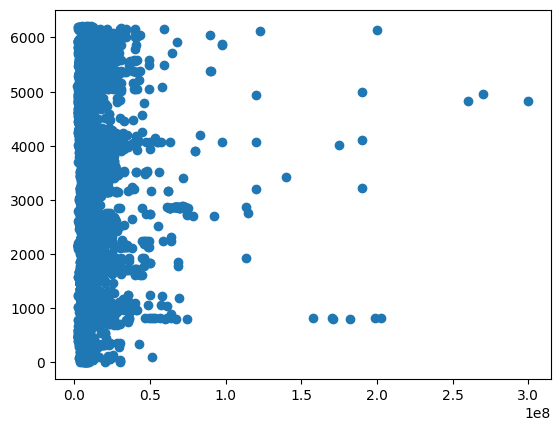

In [8]:
# plotting Price to check if scaling is required
plt.scatter(data.Price,list(range(len(data.Price))))

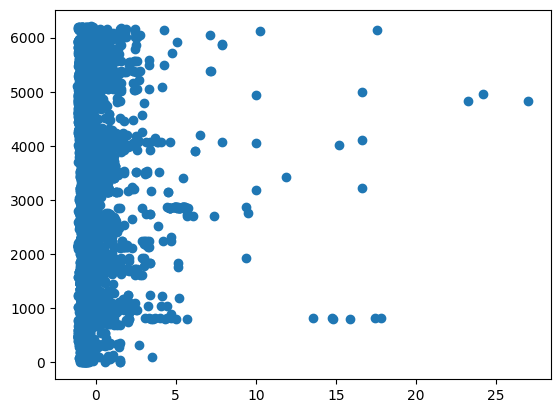

In [9]:
# some values are too large
# performing z-score normalization on price
std_dev = np.std(data.Price)
mean = np.mean(data.Price)
Price = [(i-std_dev)/mean for i in data.Price]
plt.scatter(Price,list(range(len(Price))))

Text(0, 0.5, 'Price')

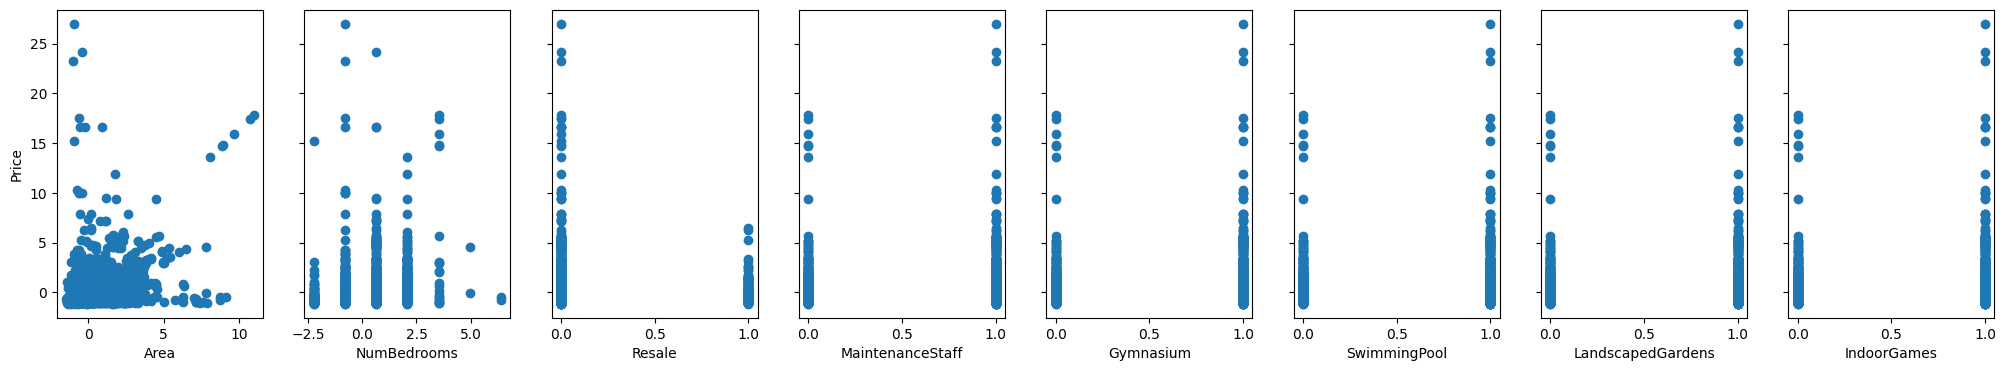

In [10]:
# combining scaled data into a single dataframe
scaled_data = pd.DataFrame()
for var in varlist:
    if var == 'Resale':
        scaled_data[var] = data.Resale
    else:
        scaled_data[var] = eval(var)

fig,ax = plt.subplots(1,8, figsize=(25,4), sharey = True)
for i in range(len(ax)):
    ax[i].scatter(scaled_data[varlist[i+1]],scaled_data[varlist[0]])
    ax[i].set_xlabel(varlist[i+1])
ax[0].set_ylabel('Price')

In [11]:
# splitting the data into training and testing data
scaled_data = scaled_data.sample(frac=1, random_state=42).reset_index(drop=True)
train_to_test_ratio = 0.7
size = int(train_to_test_ratio * len(scaled_data))

data_train = scaled_data[size:]
data_test = scaled_data[:size]

x_train = data_train[varlist[1:]].values
y_train = data_train[varlist[0]].values
           

In [12]:
#%% derived function
def predicted_y(x,w,b):
    '''
    
    Parameters
    ----------
    x : numpy.ndarray
        DESCRIPTION - array of features (x1...xn)
    w : numpy.ndarray
        DESCRIPTION - array of weights (w1...wn)
    b : float
        DESCRIPTION - bias
    Returns
    -------
    y : float
        DESCRIPTION - predicted y based on x

    '''
    f = np.dot(w,x) + b
    return f

In [13]:
# cost function
def compute_cost(x_train,y_train,w,b):
    '''
    Parameters
    ----------
    x_train : numpy.ndarray
        DESCRIPTION - training data features
    y_train : numpy.ndarray
        DESCRIPTION : training data targets
    w : numpy.ndarray
        DESCRIPTION - array of weights (w1...wn)
    b : float
        DESCRIPTION - bias
    Returns
    -------
    y : float
        DESCRIPTION - predicted y based on x

    '''
    SUM = 0
    m = x_train.shape[0]
    for i in range(m):
        x = x_train[i]
        y = y_train[i]
        
        f = predicted_y(x,w,b)
        
        SUM += (f-y)**2
    cost = SUM/(2*m)
    return cost

In [14]:
# compute gradient
def compute_gradient(x_train,y_train,w,b):
    '''
    Parameters
    ----------
    x_train : numpy.ndarray
        DESCRIPTION - training data features
    y_train : numpy.ndarray
        DESCRIPTION : training data targets
    w : numpy.ndarray
        DESCRIPTION - array of weights (w1...wn)
    b : float
        DESCRIPTION - bias
        
    Returns
    -------
    dj_dw : numpy.ndarray
        DESCRIPTION - array of gradient values for all parameters
    dj_db : numpy.float64
        DESCRIPTION - bias gradient
    '''
    SUMw = 0
    SUMb = 0
    
    m = x_train.shape[0]
    SUMw = np.zeros(8)
    SWMb = 0
    for i in range(m):
        x = x_train[i]
        y = y_train[i]

        f = predicted_y(x,w,b)
        
        SUMw += np.array([np.dot((f-y),i) for i in x])
        SUMb += f-y

    dj_dw = SUMw/m
    dj_db = SUMb/m
    
    return dj_dw, dj_db

In [15]:
#gradient descent
def gradient_descent(x_train,y_train,num_iters,alpha,w,b):
    '''
    Parameters
    ----------
    x_train : numpy.ndarray
        DESCRIPTION - training data features
    y_train : numpy.ndarray
        DESCRIPTION : training data targets
    num_iters : int
        DESCRIPTION : number of iterations
    alpha : float
        DESCRIPTION - learning rate
    w : numpy.ndarray
        DESCRIPTION - array of weights (w1...wn)
    b : float
        DESCRIPTION - bias    
    
    
    '''
    J_history = []
    w_history = []
    b_history = []
    
    m = x_train.shape[0]
    
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(x_train,y_train,w,b)
        w = w - alpha*dj_dw
        b = b - alpha*dj_db
        
        cost = compute_cost(x_train, y_train,w,b)
        J_history.append(cost)
        w_history.append(w)
        b_history.append(b)
        
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ")
                 # f"dj_dw: {dj_dw}, dj_db: {dj_db: 0.3e}  ",
                 # f"w: {w}, b:{b: 0.5e}")
        # break the loop if the cost has converged i.e. the diference in cost is less than 1e-7
        if i>1 and abs((J_history[-1]) - (J_history[-2])) <= 1e-7:    
            print('\ncost has converged')
            print(f'cost at convergence : {cost}')
            break
    print('w = {}\nb = {}'.format(w,b))
    return J_history, w_history, b_history #return w and J,w history for graphing
        

In [17]:
import time
tic = time.time()
w = np.random.normal(size=8)
b = 0
num_iters = 10000
alpha = 1e-2

# perform gradient descent
J_history, w_history, b_history = gradient_descent(x_train, y_train, num_iters, alpha, w, b)
toc = time.time()
time = (toc-tic)/60
print(f'time : {time}')

Iteration    0: Cost 4.75e+00 
Iteration 1000: Cost 5.41e-01 
Iteration 2000: Cost 5.35e-01 
Iteration 3000: Cost 5.34e-01 
Iteration 4000: Cost 5.33e-01 

cost has converged
cost at convergence : 0.5334276415061889
w = [ 0.54324908 -0.10887584 -0.24724981 -0.5658217  -0.18578141 -0.5217271
 -0.35560001  1.67178049]
b = -0.3770995439354063
time : 3.5887452483177187


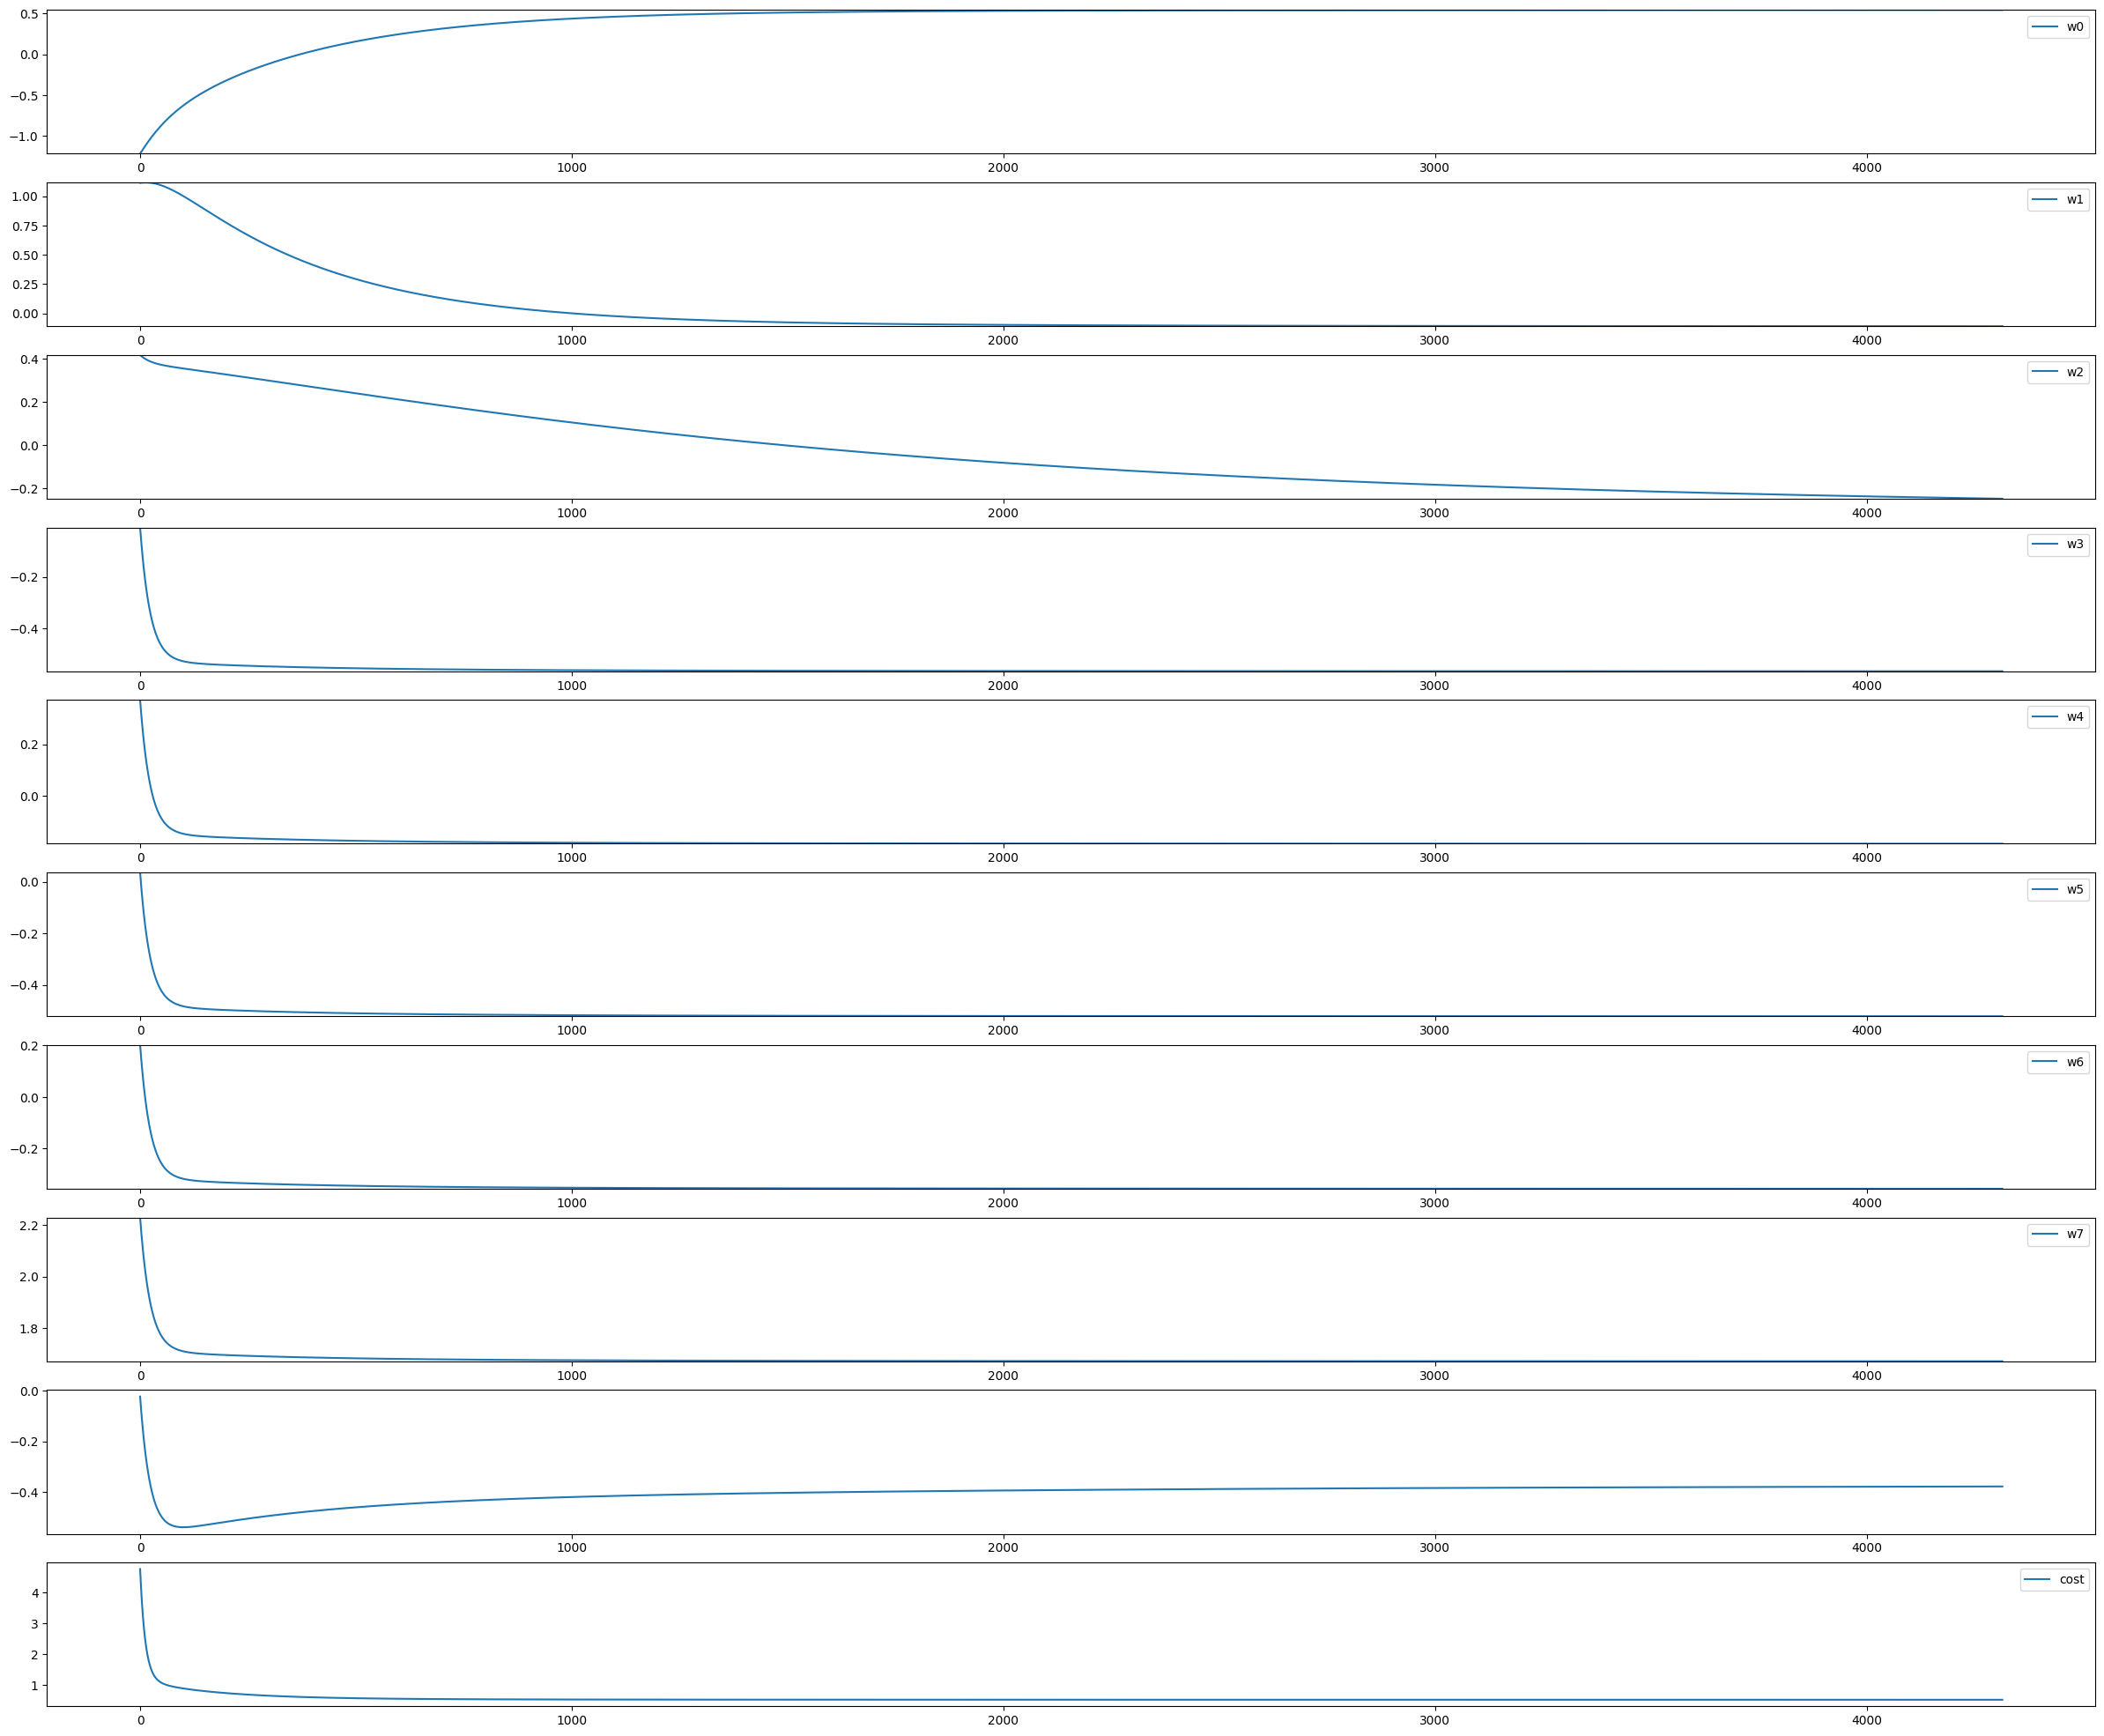

In [47]:
fig,ax = plt.subplots(10,1, figsize=(30,25), )
for i in range(8):
    ax[i].plot(np.array(w_history)[:,i], label=(f'w{i}'))
    ax[i].legend()
    ax[i].set_ylim((min(np.array(w_history)[:,i])),max(np.array(w_history)[:,i]))
ax[8].plot(b_history, label='b')
ax[9].plot(J_history, label='cost')
plt.legend()